Rotates given morphologies of neurons with apical dendrites on the top, and basal on the bottom

In [1]:
import numpy as np
import os
import matplotlib.pylab as plt

from eap import field, cell, graph
import lib.helper as hl 
import lib.cell_support as cs
import lib.cell_plot as cplt

% matplotlib inline

In [2]:
# set paths
current_dir = os.getcwd()
dir_morpho_raw = os.path.join(current_dir,
                                  'data/raw_cells')# raw morphologies in .swc format (as loaded from neuromorpho.org)
dir_morpho_vertical = os.path.join(current_dir,
                                       'data/vertical')# where to save vertical morpho
# remove axon from the saved file or not
remove_axon = True

In [3]:
# find all the swc files in the dir_morpho_vertical
hl.create_folder(dir_morpho_vertical)
swc_files = hl.find_files(dir_name=dir_morpho_raw,ext='swc')
print 'loading ', str(len(swc_files)), 'files from ', dir_morpho_raw

loading  1 files from  /home/maria/maja/code/lfp-paper/data/raw_cells


In [4]:
for idx,morpho_file in enumerate(swc_files):
    print idx+1,'/',len(swc_files), ', translating to vertical ', morpho_file
    # rotate through each .swc file
    swc_segs_raw = cs.load_swc_segs(dir_morpho_raw, morpho_file, rmv_nodes_with_no_parent=False)

    # calculate mean weight
    basal_dendrite = swc_segs_raw[swc_segs_raw['name'] == 'basal_dendrite']
    apical_dendrite = swc_segs_raw[swc_segs_raw['name'] == 'apical_dendrite']
    
    # check if there are any basal and apical dendrites
    assert len(basal_dendrite) != 0 or len(apical_dendrite) != 0, 'cannot rotate, no dendrites has been detected'
    print 'detected ', len(basal_dendrite), ' basal and ', len(apical_dendrite), ' apical dendrites'
    
    if len(basal_dendrite) != 0 and len(apical_dendrite) != 0:
        # rotate if both basal and apical dendrites detected
        x_basal, y_basal, z_basal = cs.calc_mean_segs(basal_dendrite)
        x_apical, y_apical, z_apical = cs.calc_mean_segs(apical_dendrite)
        a_line, b_line, radians = hl.calc_ab_line_given_pts(x_basal, x_apical, y_basal, y_apical)

        # rotate the cell
        x_angle = 0
        y_angle = 0
        z_angle = -cs.radians_to_angle(radians)

        if y_apical < y_basal:
            z_angle += 180
        new_segs = cs.rotate_cell(swc_segs_raw, x_angle=x_angle, y_angle=y_angle, z_angle=z_angle)
   
    elif len(basal_dendrite) != 0: # perhaps only basal dendrites?
        # assume that soma center is already at (000)
        soma_center_temp = (0, 0)

        # peform principal component analysis
        data = np.zeros([len(basal_dendrite), 3])
        coords = basal_dendrite[['x0', 'y0']]#, 'z0']]
        data[:,0] = coords['x0']
        data[:,1] = coords['y0']

        eigenvectors = cs.calc_principal_components(data, plotit=True)
        projected_data = np.dot(data, eigenvectors)
        mu = data.mean(axis=0)

        # shift main principal component to the soma
        sigma = projected_data.std(axis=0).mean()
        start, end = mu, mu + sigma * eigenvectors[0]
        end -= start
        start -=start

        a_line, b_line, radians = hl.calc_ab_line_given_pts(start[0], end[0], start[1], end[1])
        # rotate the cell
        x_angle = 0
        y_angle = 0
        z_angle = -cs.radians_to_angle(radians)

        if start[1] < end[1]:
            z_angle += 180

        new_segs = cs.rotate_cell(swc_segs_raw, x_angle=x_angle, y_angle=y_angle, z_angle=z_angle)

    else:
        assert False, 'rotation for only apical dendrites has not been written'

    if remove_axon:
        print 'removing axon'
        # remove axon from the calculations!!!!
        only_axon = cell.select_sections(new_segs, 'axon')
        new_segs = new_segs[np.invert(only_axon)]

    # save the new segments
    cs.save_swc_segs(dir_morpho_vertical, morpho_file, new_segs)

    print 'new files were saved in ', dir_morpho_vertical


1 / 1 , translating to vertical  c10861.CNG.swc
detected  1315  basal and  800  apical dendrites


lib/cell_support.py:66: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if soma_seg == 1:


removing axon
new files were saved in  /home/maria/maja/code/lfp-paper/data/vertical


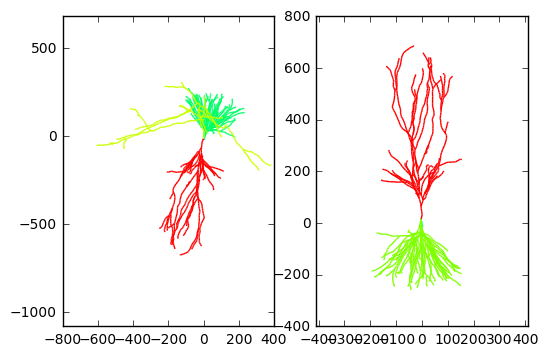

In [5]:
import lib.cell_plot as cplot
# this will draw just the last cell analysed

# draw raw morphology
plt.subplot(121)
cplot.plot_from_segs(swc_segs_raw, color_what='segs')

# draw vertical morphology
plt.subplot(122)
cplot.plot_from_segs(new_segs, color_what='segs')

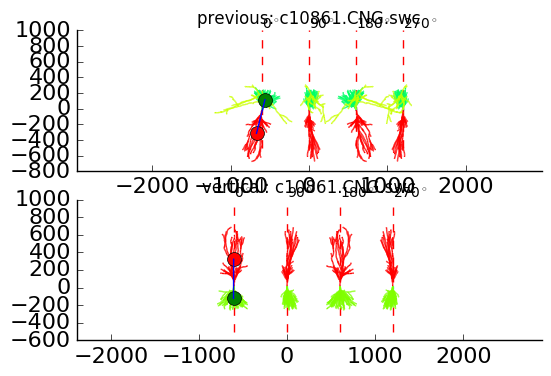

In [6]:
plt.figure()

ax = plt.subplot(211)
cplt.plot_rotate_morpho(swc_segs_raw, title='previous: '+morpho_file, ax=None, color_what='segs')
if len(apical_dendrite) > 0 and len(basal_dendrite) > 0:
    plt.plot(x_apical - 600, y_apical, 'ro', ms=10)
    plt.plot(x_basal - 600, y_basal, 'go', ms=10)
    plt.plot([x_basal-600, x_apical-600], [y_basal, y_apical])

cplt.clean_plot(ax)

ax2 = plt.subplot(212)
basal_dendrite = new_segs[new_segs['name'] == 'basal_dendrite']
apical_dendrite = new_segs[new_segs['name'] == 'apical_dendrite']
x_basal, y_basal, z_basal = cs.calc_mean_segs(basal_dendrite)
x_apical, y_apical, z_apical = cs.calc_mean_segs(apical_dendrite)
cplt.plot_rotate_morpho(new_segs, title='vertical: ' + morpho_file, ax=None, color_what='segs')
plt.plot(x_apical - 600, y_apical, 'ro', ms=10)
plt.plot(x_basal - 600, y_basal, 'go', ms=10)
plt.plot([x_basal - 600, x_apical - 600], [y_basal, y_apical])
cplt.clean_plot(ax2)